In [1]:
from google.colab import drive
drive.mount('/colab')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /colab


In [0]:
!cp -r "/colab/My Drive/Vision_task_dataset_public" "./"

In [0]:
import pickle
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split as tts
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import cv2

In [0]:
with open('Vision_task_dataset_public/train_image.pkl', 'rb') as file:
    train_data = pickle.load(file)

In [3]:
print(type(train_data),len(train_data))

<class 'list'> 8000


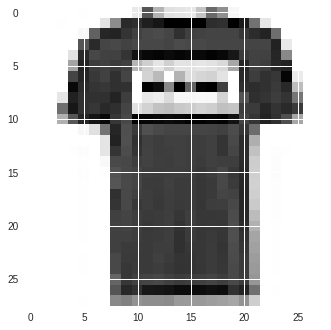

In [4]:
x = np.array(train_data[0]).reshape(28,28)
plt.imshow(x)

In [0]:
train_data = np.array(train_data).reshape(8000,28,28)

In [0]:
with open('Vision_task_dataset_public/train_label.pkl', 'rb') as file:
    train_label = pickle.load(file)

In [7]:
np.unique(train_label,return_counts=True)

(array([0, 2, 3, 6]), array([2000, 2000, 2000, 2000]))

In [0]:
train_labels = np.array(train_label).reshape(-1,1)

In [9]:
enc = OneHotEncoder(handle_unknown='ignore',sparse=True)
train_labels = enc.fit_transform(train_labels).toarray()
print(train_labels.shape)
enc.categories_

(8000, 4)


[array([0, 2, 3, 6])]

In [0]:
train_data = np.reshape(train_data,(-1,28,28,1))
x_train,x_val,y_train,y_val = tts(train_data,train_labels,random_state = 5,test_size = 0.1,shuffle = True)

In [25]:
M = np.float32([[1, 0, 5], [0, 1, 5]])
for i in tqdm(range(len(x_train))):
  x = x_train[i]
  x=x.astype(np.float32)
  y = y_train[i].reshape(1,4)
  x1 = np.fliplr(x).reshape(1,28,28,1)
  x2 = np.flipud(x).reshape(1,28,28,1)
  x3 = np.rot90(x).reshape(1,28,28,1)
  x4 = cv2.warpAffine(x, M, (28, 28))
  x5 = np.flipud(x4).reshape(1,28,28,1)
  x4 = x4.reshape(1,28,28,1)
  x_train = np.concatenate((x_train,x2),axis=0)
  x_train = np.concatenate((x_train,x3),axis=0)
  x_train = np.concatenate((x_train,x1),axis=0)
  x_train = np.concatenate((x_train,x4),axis=0)
  x_train = np.concatenate((x_train,x5),axis=0)
  for j in range(5):
    y_train = np.concatenate((y_train,y),axis=0)

100%|██████████| 7200/7200 [20:00<00:00,  3.51it/s]


In [0]:
mean = 0
var = 0.1
sigma = var**0.5
for i in range(500):
  gauss = np.random.normal(mean,sigma,(28,28,1)).reshape(1,28,28,1)
  y = y_train[456+i].reshape(1,4)
  x_train = np.concatenate((x_train,gauss),axis=0)
  y_train = np.concatenate((y_train,y),axis=0)

In [0]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [35]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((44200, 28, 28, 1), (44200, 4), (800, 28, 28, 1), (800, 4))

In [0]:
from keras import Model
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten, Convolution2D, Activation, BatchNormalization, MaxPool2D
from keras.layers.advanced_activations import LeakyReLU, PReLU

In [37]:
model = Sequential()

model.add(Convolution2D(16, (3,3), padding='same', use_bias=False, input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))

# model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))

# model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Convolution2D(512, (3,3), use_bias=False))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))

model.add(Convolution2D(64, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
          
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        4608      
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 32)        0         
__________

In [0]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
model.fit(x_train,y_train,batch_size=64,epochs=50,validation_data=(x_val,y_val))

Train on 44200 samples, validate on 800 samples
Epoch 1/50
44200/44200 [==============================] - 9s 214us/step - loss: 0.6078 - acc: 0.7498 - val_loss: 0.3958 - val_acc: 0.8575
Epoch 2/50
44200/44200 [==============================] - 9s 197us/step - loss: 0.4575 - acc: 0.8167 - val_loss: 0.3969 - val_acc: 0.8350
Epoch 3/50
44200/44200 [==============================] - 9s 203us/step - loss: 0.4000 - acc: 0.8398 - val_loss: 0.4915 - val_acc: 0.8012
Epoch 4/50
44200/44200 [==============================] - 9s 195us/step - loss: 0.3625 - acc: 0.8524 - val_loss: 0.4143 - val_acc: 0.8512
Epoch 5/50
44200/44200 [==============================] - 9s 197us/step - loss: 0.3303 - acc: 0.8647 - val_loss: 0.3252 - val_acc: 0.8863
Epoch 6/50
44200/44200 [==============================] - 9s 197us/step - loss: 0.3059 - acc: 0.8749 - val_loss: 0.3149 - val_acc: 0.8750
Epoch 7/50
44200/44200 [==============================] - 9s 198us/step - loss: 0.2824 - acc: 0.8846 - val_loss: 0.3412 - va